In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os  # For interacting with the operating system
import torch  # PyTorch library for deep learning
import torchvision  # Provides access to popular datasets, model architectures, and image transformations
from torch.utils.data import random_split  # For splitting datasets into train and validation sets
import torchvision.models as models  # Pre-trained models available in torchvision
import torch.nn as nn  # Neural network module in PyTorch
import torch.nn.functional as F  # Functional interface for operations on tensors

import matplotlib.pyplot as plt  # Matplotlib for plotting

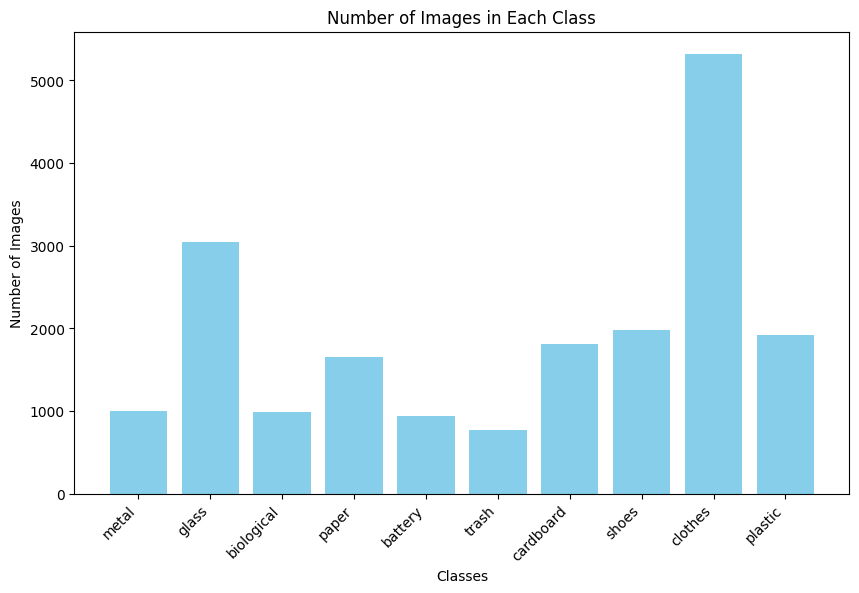

In [2]:
data_dir  = '/kaggle/input/garbage-classification-v2/garbage-dataset'

classes = os.listdir(data_dir)
# Initialize a dictionary to store the count of images in each class
class_count = {}

# Loop through each class folder
for class_name in classes:
    # Count the number of images in the class folder
    class_count[class_name] = len(os.listdir(os.path.join(data_dir, class_name)))

# Plot the number of images in each class
plt.figure(figsize=(10, 6))
plt.bar(class_count.keys(), class_count.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.show()

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: battery (Class No: 0)


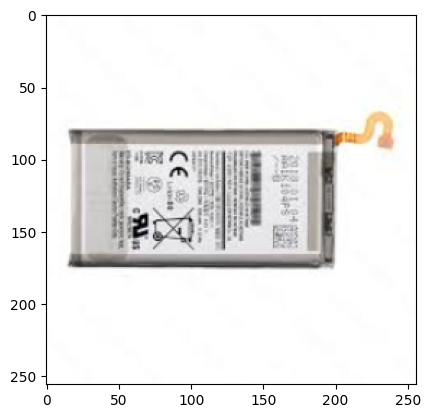

In [5]:
img, label = dataset[12]
show_sample(img, label)

In [6]:
random_seed = 16
torch.manual_seed(random_seed)

In [7]:
len(dataset)

19407

In [8]:
train_ds, test_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_ds, val_ds = random_split(train_ds, [int(0.8 * len(train_ds)), len(train_ds) - int(0.8 * len(train_ds))])

In [9]:
print(len(train_ds), len(test_ds), len(val_ds))

12420 3882 3105


In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

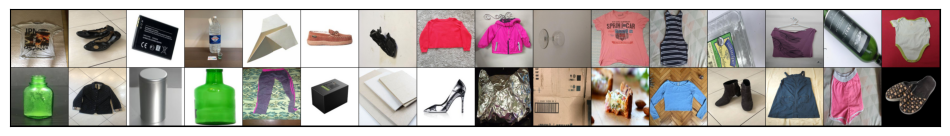

In [13]:
show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
resnet_model = models.resnet50(pretrained=True)

print(resnet_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_baseline = ResNet()

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model_baseline, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model_baseline = to_device(ResNet(), device)

In [22]:
evaluate(model_baseline, val_dl)

{'val_loss': 2.314723014831543, 'val_acc': 0.037308674305677414}

In [23]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5e-4

history = fit(num_epochs, lr, model_baseline, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.6944, val_loss: 1.7315, val_acc: 0.6641
Epoch 2: train_loss: 1.6349, val_loss: 1.6667, val_acc: 0.7396
Epoch 3: train_loss: 1.6128, val_loss: 1.5965, val_acc: 0.8340
Epoch 4: train_loss: 1.5872, val_loss: 1.5900, val_acc: 0.8298
Epoch 5: train_loss: 1.5773, val_loss: 1.5806, val_acc: 0.8441
Epoch 6: train_loss: 1.5683, val_loss: 1.6055, val_acc: 0.8177
Epoch 7: train_loss: 1.5679, val_loss: 1.5760, val_acc: 0.8563
Epoch 8: train_loss: 1.5424, val_loss: 1.5528, val_acc: 0.8884
Epoch 9: train_loss: 1.5557, val_loss: 1.5606, val_acc: 0.8814
Epoch 10: train_loss: 1.5307, val_loss: 1.5526, val_acc: 0.8833


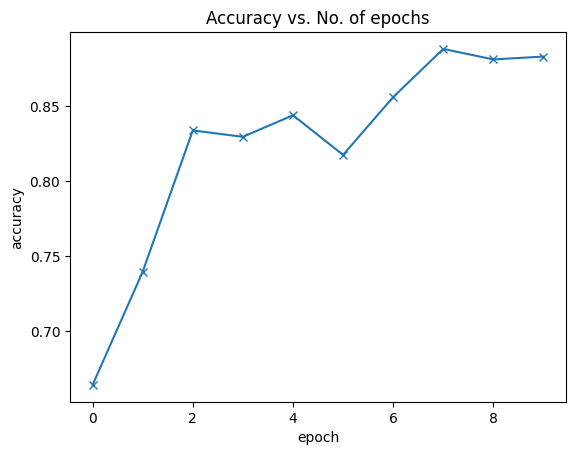

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

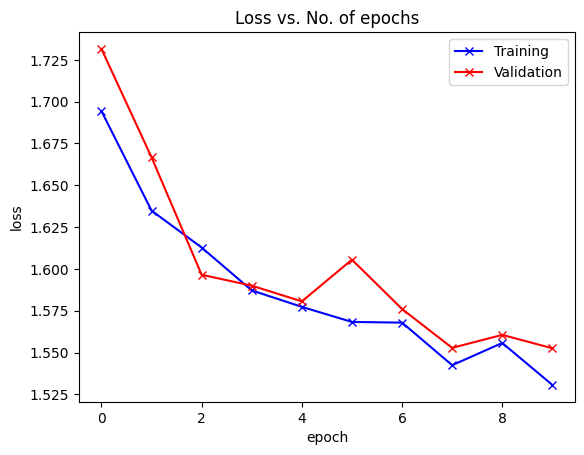

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [26]:
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=20),   # Random rotation
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),  # Random zoom and crop
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Random height and width shift
    transforms.ToTensor()  # Convert PIL image to Tensor
])

dataset = ImageFolder(data_dir, transform=data_augmentation)

Label: battery (Class No: 0)


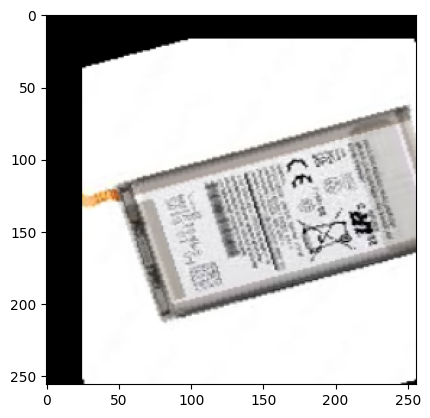

In [27]:
img, label = dataset[12]
show_sample(img, label)

In [28]:
# Validation dataset without augmentation
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Apply transforms to datasets
train_ds = ImageFolder(data_dir, transform=data_augmentation)
val_ds = ImageFolder(data_dir, transform=val_transform)

In [29]:
random_seed = 16
torch.manual_seed(random_seed)

In [30]:
train_ds, test_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_ds, val_ds = random_split(train_ds, [int(0.8 * len(train_ds)), len(train_ds) - int(0.8 * len(train_ds))])

In [31]:
print(len(train_ds), len(test_ds), len(val_ds))

12420 3882 3105


In [32]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [33]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [34]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained ResNet model
        self.network = models.resnet50(pretrained=True)
        
        # Get the number of input features for the last layer
        num_ftrs = self.network.fc.in_features
        
        # Replace the fully connected layer with a custom sequential layer
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),   # First hidden layer
            nn.BatchNorm1d(256),       # Batch Normalization
            nn.ReLU(),                 # Activation
            nn.Dropout(0.5),           # Dropout
            nn.Linear(256, 128),       # Second hidden layer
            nn.ReLU(),                 # Activation
            nn.Linear(128, len(dataset.classes))  # Output layer
        )
    
    def forward(self, xb):
        return self.network(xb)

model_enchanced = ResNet()

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model_enchanced, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [37]:
model_enchanced = to_device(ResNet(), device)

In [38]:
evaluate(model_enchanced, val_dl)

{'val_loss': 2.2646312713623047, 'val_acc': 0.26445579528808594}

In [39]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-5

history = fit(num_epochs, lr, model_enchanced, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.6276, val_loss: 1.0292, val_acc: 0.8461
Epoch 2: train_loss: 0.9539, val_loss: 0.5831, val_acc: 0.9066
Epoch 3: train_loss: 0.6407, val_loss: 0.3668, val_acc: 0.9493
Epoch 4: train_loss: 0.4532, val_loss: 0.2718, val_acc: 0.9513
Epoch 5: train_loss: 0.3359, val_loss: 0.2207, val_acc: 0.9560
Epoch 6: train_loss: 0.2610, val_loss: 0.1782, val_acc: 0.9640
Epoch 7: train_loss: 0.1984, val_loss: 0.1695, val_acc: 0.9585
Epoch 8: train_loss: 0.1598, val_loss: 0.1468, val_acc: 0.9652
Epoch 9: train_loss: 0.1328, val_loss: 0.1391, val_acc: 0.9621
Epoch 10: train_loss: 0.1052, val_loss: 0.1280, val_acc: 0.9688


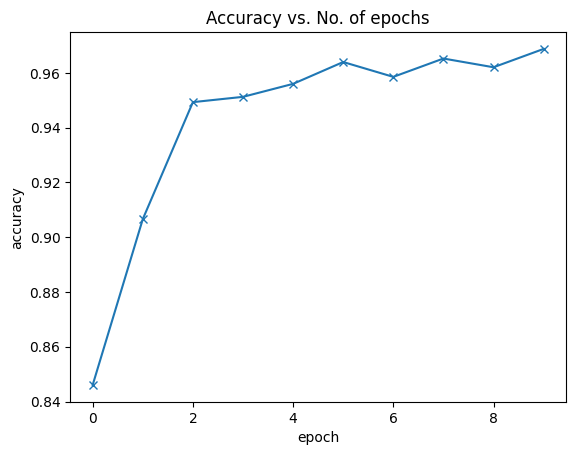

In [40]:
plot_accuracies(history)

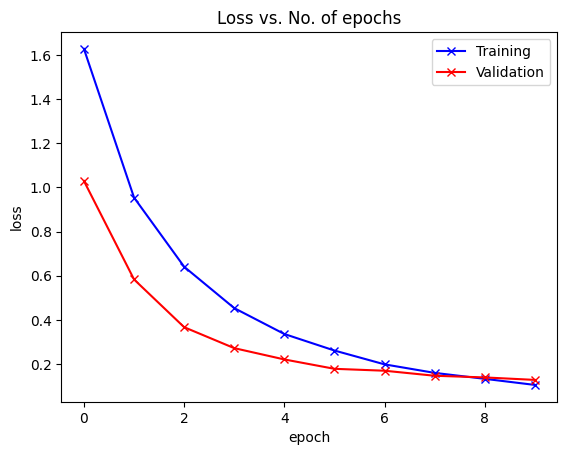

In [41]:
plot_losses(history)

In [42]:
!pip install dill

import dill

torch.save(model_baseline, "baseline_model_full.pth", pickle_module=dill)
torch.save(model_enchanced, "enchanced_model_full.pth", pickle_module=dill)

In [ ]:
j